# Using a Pre-Trained Model for Cost Effective Data Labeling

1. [Introduction](#Introduction)
2. [Iteration #1: Create Initial Labeling Job](#Iteration1)
3. [Iteration #2: Labeling Job with Pre-Trained Model](#Iteration2)
3. [Iteration #3: Second Data Subset Without Pre-Trained Model](#Iteration3)
4. [Conclusion](#Conclusion)

# Introduction <a class="anchor" id="Introduction"></a>

SageMaker Ground Truth is a fully managed service for labeling datasets for machine learning applications. Ground Truth allows you to start a labeling job with a pre-trained model, which is a great way to accelerate the labeling process. If you have a machine learning model that already encodes some domain knowledge about your dataset, you can use it to "jump start" Ground Truth's auto-labeling process. 

This example takes you through an end-to-end workflow to demonstrate the use of pre-trained models with SageMaker Ground Truth. We'll proceed in two parts. First, we'll start with an unlabeled image dataset and acquire labels using SageMaker Ground Truth. Then we'll create a new labeling job with a held-out dataset, and we'll provide the machine learning model that was trained for us in the previous step by SageMkaer Ground Truth. In the end, we'll see how much the second labeling job benefitted from the knowledge acquired during the first labeling job!

### Cost and runtime
<TBD>

### Prerequisites
This notebook builds off the the examples and lessons from our [beginner notebook for object detection labeling jobs](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/ground_truth_labeling_jobs/ground_truth_object_detection_tutorial/object_detection_tutorial.ipynb). If you haven't already done so, we highly recommend that you familiarize yourself with this notebook before proceeding.

To run this notebook, you can simply execute each cell in order. To understand what's happening, you'll need:
* An S3 bucket you can write to -- please provide its name in the following cell. The bucket must be in the same region as this SageMaker Notebook instance. You can also change the `EXP_NAME` to any valid S3 prefix. All the files related to this experiment will be stored in that prefix of your bucket. 
* Familiarity with Python and [numpy](http://www.numpy.org/).
* Basic familiarity with [AWS S3](https://docs.aws.amazon.com/s3/index.html).
* Basic understanding of [AWS Sagemaker](https://aws.amazon.com/sagemaker/).
* Basic familiarity with [AWS Command Line Interface (CLI)](https://aws.amazon.com/cli/) -- ideally, you should have it set up with credentials to access the AWS account you're running this notebook from.

This notebook has only been tested on a SageMaker notebook instance. The runtimes given are approximate. We used an `ml.m4.xlarge` instance in our tests. However, you can likely run it on a local instance by first executing the cell below on SageMaker and then copying the `role` string to your local copy of the notebook.

In [1]:
%matplotlib inline
import os
from collections import namedtuple
from collections import defaultdict
from collections import Counter
from datetime import datetime
import itertools
import base64
import glob
import json
import random
import time
import imageio
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import shutil
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import confusion_matrix
import boto3
import botocore
import sagemaker
from urllib.parse import urlparse

BUCKET = '<< YOUR S3 BUCKET NAME >>'
BUCKET = 'jonabuck-us-west-2'
EXP_NAME = 'ground-truth-pretrained-model-demo'
EXP_NAME_1 = EXP_NAME + '/iteration-1' # Any valid S3 prefix.
EXP_NAME_2 = EXP_NAME + '/iteration-2' # Any valid S3 prefix.
EXP_NAME_3 = EXP_NAME + '/iteration-3' # Any valid S3 prefix.



In [3]:
# Make sure the bucket is in the same region as this notebook.
role = sagemaker.get_execution_role()
region = boto3.session.Session().region_name
s3 = boto3.client('s3')
bucket_region = s3.head_bucket(Bucket=BUCKET)['ResponseMetadata']['HTTPHeaders']['x-amz-bucket-region']
assert bucket_region == region, "Your S3 bucket {} and this notebook need to be in the same region.".format(BUCKET)

sagemaker_client = boto3.client('sagemaker')

# Iteration #1: Create Initial Labeling Job

## Setup

**This section should take about 4 hours to complete.**

We will first run a labeling job. This involves several steps: collecting the images we want annotated, creating instructions, and writing a labeling job specification. Using a public workforce, this section should take about 4 hours. However, this will vary depending on the availability of workers.

### Prepare the data
We will first download images and labels of a subset of the [Google Open Images Dataset](https://storage.googleapis.com/openimages/web/index.html). These labels were [carefully verified](https://storage.googleapis.com/openimages/web/factsfigures.html). Later, we will compare Ground Truth annotations to these labels. Our dataset will consist of images of various species of bird.

This is a diverse dataset of interesting images, and it should be fun for the human annotators to work with. You are free to ask the annotators to annotate any images you wish as long as the images do not contain adult content. In this case, you must adjust the labeling job request this job produces; please check the Ground Truth documentation.

We will copy these images to our local `BUCKET` and create a corresponding *input manifest*. The input manifest is a formatted list of the S3 locations of the images we want Ground Truth to annotate. We will upload this manifest to our S3 `BUCKET`.

#### Disclosure regarding the Open Images Dataset V4:
Open Images Dataset V4 is created by Google Inc. We have not modified the images or the accompanying annotations. You can obtain the images and the annotations [here](https://storage.googleapis.com/openimages/web/download.html). The annotations are licensed by Google Inc. under [CC BY 4.0](https://creativecommons.org/licenses/by/2.0/) license. The images are listed as having a [CC BY 2.0](https://creativecommons.org/licenses/by/2.0/) license. The following paper describes Open Images V4 in depth: from the data collection and annotation to detailed statistics about the data and evaluation of models trained on it.

A. Kuznetsova, H. Rom, N. Alldrin, J. Uijlings, I. Krasin, J. Pont-Tuset, S. Kamali, S. Popov, M. Malloci, T. Duerig, and V. Ferrari.
*The Open Images Dataset V4: Unified image classification, object detection, and visual relationship detection at scale.* arXiv:1811.00982, 2018. ([link to PDF](https://arxiv.org/abs/1811.00982))

In [ ]:
# Download and process the Open Images annotations.
!wget https://storage.googleapis.com/openimages/2018_04/test/test-annotations-bbox.csv
!wget https://storage.googleapis.com/openimages/2018_04/bbox_labels_600_hierarchy.json
    
with open('bbox_labels_600_hierarchy.json', 'r') as f:
    hierarchy = json.load(f)
    
CLASS_NAME = 'Bird'
CLASS_ID = '/m/015p6'
NUM_IMGS = 2500

# Find all the subclasses of the desired image class (e.g. 'swans' and 'pigeons' etc if CLASS_NAME=='Bird').
good_subclasses = set()
def get_all_subclasses(hierarchy, good_subtree=False):
    if hierarchy['LabelName'] == CLASS_ID:
        good_subtree = True
    if good_subtree:
        good_subclasses.add(hierarchy['LabelName'])
    if 'Subcategory' in hierarchy:            
        for subcat in hierarchy['Subcategory']:
            get_all_subclasses(subcat, good_subtree=good_subtree)
    return good_subclasses
good_subclasses = get_all_subclasses(hierarchy)



fids2bbs = defaultdict(list)
# Skip images with risky content.
skip_these_images = ['251d4c429f6f9c39', 
                    '065ad49f98157c8d']

with open('test-annotations-bbox.csv', 'r') as f:
    for line in f.readlines()[1:]:
        
        line = line.strip().split(',')
        img_id, _, cls_id, conf, xmin, xmax, ymin, ymax, *_ = line
        if img_id in skip_these_images:
            continue
        copy_source = {
            'Bucket': 'open-images-dataset',
            'Key': 'test/{}.jpg'.format(img_id)
        }
        
        if cls_id in good_subclasses:
            if s3.head_object(**copy_source)['ContentLength']/1024**2 > 6:
                continue # skip images larger than 6 MB
            fids2bbs[img_id].append([CLASS_NAME, xmin, xmax, ymin, ymax])
        
        if len(fids2bbs) == NUM_IMGS:
                break

# Copy the images to our local bucket.
s3 = boto3.client('s3')
for img_id_id, img_id in enumerate(fids2bbs.keys()):
    if img_id_id % 100 == 0:
        print('Copying image {} / {}'.format(img_id_id, NUM_IMGS))
    copy_source = {
        'Bucket': 'open-images-dataset',
        'Key': 'test/{}.jpg'.format(img_id)
    }
    s3.copy(copy_source, BUCKET, '{}/images/{}.jpg'.format(EXP_NAME, img_id))
print('Done!')                
                
# Split dataset into two subsets
first_iteration_dataset = list(fids2bbs.keys())[:len(fids2bbs.keys())//2]
second_iteration_dataset = list(fids2bbs.keys())[len(fids2bbs.keys())//2:]

manifest_name_iteration_1 = 'iteration-1-input.manifest'
with open(manifest_name_iteration_1, 'w') as f:
    for img in first_iteration_dataset:
        img_path = 's3://{}/{}/images/{}.jpg'.format(BUCKET, EXP_NAME, img)
        f.write('{"source-ref": "' + img_path +'"}\n')
s3.upload_file(manifest_name_iteration_1, BUCKET, EXP_NAME_1 + '/' + manifest_name_iteration_1)

manifest_name_iteration_2 = 'iteration-2-input.manifest'
with open(manifest_name_iteration_2, 'w') as f:
    for img in second_iteration_dataset:
        img_path = 's3://{}/{}/images/{}.jpg'.format(BUCKET, EXP_NAME, img)
        f.write('{"source-ref": "' + img_path +'"}\n')
s3.upload_file(manifest_name_iteration_2, BUCKET, EXP_NAME_2 + '/' + manifest_name_iteration_2)

--2019-05-14 19:09:07--  https://storage.googleapis.com/openimages/2018_04/test/test-annotations-bbox.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.0.48, 2607:f8b0:400a:803::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.0.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52174204 (50M) [text/csv]
Saving to: ‘test-annotations-bbox.csv.12’

test-annotations-bb 100%[===================>]  49.76M  25.1MB/s    in 2.0s    

2019-05-14 19:09:10 (25.1 MB/s) - ‘test-annotations-bbox.csv.12’ saved [52174204/52174204]

--2019-05-14 19:09:11--  https://storage.googleapis.com/openimages/2018_04/bbox_labels_600_hierarchy.json
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.14.208, 2607:f8b0:4005:802::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.14.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86291 (84K) [text/csv]
Saving to: ‘bbox_labe

After running the cell above, you should be able to go to `s3://BUCKET/EXP_NAME/images` in the [S3 console](https://console.aws.amazon.com/s3/) and see 2500 images. We recommend you inspect these images! You can download them to a local machine using the AWS CLI.

## Specify the categories

To run an object detection labeling job, you must decide on a set of classes the annotators can choose from. At the moment, Ground Truth only supports annotating one OD class at a time. In our case, the singleton class list is simply `["Bird"]`.  To work with Ground Truth, this list needs to be converted to a .json file and uploaded to the S3 `BUCKET`.

In [6]:
CLASS_LIST = [CLASS_NAME]
print("Label space is {}".format(CLASS_LIST))

json_body = {
    'labels': [{'label': label} for label in CLASS_LIST]
}
with open('class_labels.json', 'w') as f:
    json.dump(json_body, f)
    
s3.upload_file('class_labels.json', BUCKET, EXP_NAME + '/class_labels.json')

Label space is ['Bird']


You should now see `class_labels.json` in `s3://BUCKET/EXP_NAME/`.

## Create the instruction template

Part or all of your images will be annotated by human annotators. It is **essential** to provide good instructions. Good instructions are:
1. Concise. We recommend limiting verbal/textual instruction to two sentences and focusing on clear visuals.
2. Visual. In the case of object detection, we recommend providing several labeled examples with different numbers of boxes.

When used through the AWS Console, Ground Truth helps you create the instructions using a visual wizard. When using the API, you need to create an HTML template for your instructions. Below, we prepare a very simple but effective template and upload it to your S3 bucket.

NOTE: If you use any images in your template (as we do), they need to be publicly accessible. You can enable public access to files in your S3 bucket through the S3 Console, as described in [S3 Documentation](https://docs.aws.amazon.com/AmazonS3/latest/user-guide/set-object-permissions.html). 

#### Testing your instructions
**It is very easy to create broken instructions.** This might cause your labeling job to fail. However, it might also cause your job to complete with meaningless results if, for example, the annotators have no idea what to do or the instructions are misleading. At the moment the only way to test the instructions is to run your job in a private workforce. This is a way to run a mock labeling job for free. We describe how in [Verify your task using a private team [OPTIONAL]](#Verify-your-task-using-a-private-team-[OPTIONAL]).

It is helpful to show examples of correctly labeled images in the instructions. The following code block produces several such examples for our dataset and saves them in `s3://BUCKET/EXP_NAME/`.

download: s3://open-images-dataset/test/000411001ff7dd4f.jpg to ./000411001ff7dd4f.jpg
download: s3://open-images-dataset/test/0027f99a032cca4a.jpg to ./0027f99a032cca4a.jpg


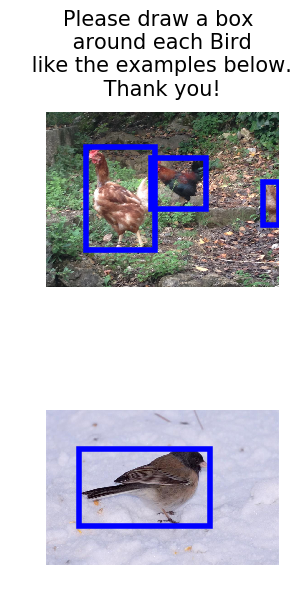

In [7]:
# Plot sample images.
def plot_bbs(ax, bbs, img):
    '''Add bounding boxes to images.'''
    ax.imshow(img)
    imh, imw, _ = img.shape
    for bb in bbs:
        xmin, xmax, ymin, ymax = bb
        xmin *= imw
        xmax *= imw
        ymin *= imh
        ymax *= imh
        rec = plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=None, lw=4, edgecolor='blue')
        ax.add_patch(rec)
        
plt.figure(facecolor='white', dpi=100, figsize=(3, 7))
plt.suptitle('Please draw a box\n around each {}\n like the examples below.\n Thank you!'.format(CLASS_NAME), fontsize=15)
for fid_id, (fid, bbs) in enumerate([list(fids2bbs.items())[idx] for idx in [1, 3]]):
    !aws s3 cp s3://open-images-dataset/test/{fid}.jpg .
    img = imageio.imread(fid + '.jpg')
    bbs = [[float(a) for a in annot[1:]] for annot in bbs]
    ax = plt.subplot(2, 1, fid_id+1)
    plot_bbs(ax, bbs, img)
    plt.axis('off')
    
plt.savefig('instructions.png', dpi=60)
with open('instructions.png', 'rb') as instructions:
    instructions_uri = base64.b64encode(instructions.read()).decode('utf-8').replace('\n', '')

In [8]:
from IPython.core.display import HTML, display

def make_template(test_template=False, save_fname='instructions.template'):
    template = r"""<script src="https://assets.crowd.aws/crowd-html-elements.js"></script>
    <crowd-form>
      <crowd-bounding-box
        name="boundingBox"
        src="{{{{ task.input.taskObject | grant_read_access }}}}"
        header="Dear Annotator, please draw a tight box around each {class_name} you see (if there are more than 8 birds, draw boxes around at least 8). Thank you!"
        labels="{labels_str}"
      >
        <full-instructions header="Please annotate each {class_name}.">

    <ol>
        <li><strong>Inspect</strong> the image</li>
        <li><strong>Determine</strong> if the specified label is/are visible in the picture.</li>
        <li><strong>Outline</strong> each instance of the specified label in the image using the provided “Box” tool.</li>
    </ol>
    <ul>
        <li>Boxes should fit tight around each object</li>
        <li>Do not include parts of the object are overlapping or that cannot be seen, even though you think you can interpolate the whole shape.</li>
        <li>Avoid including shadows.</li>
        <li>If the target is off screen, draw the box up to the edge of the image.</li>
    </ul>

        </full-instructions>
        <short-instructions>
        <img src="data:image/png;base64,{instructions_uri}" style="max-width:100%">
        </short-instructions>
      </crowd-bounding-box>
    </crowd-form>
    """.format(class_name=CLASS_NAME,
               instructions_uri=instructions_uri,
               labels_str=str(CLASS_LIST) if test_template else '{{ task.input.labels | to_json | escape }}')
    with open(save_fname, 'w') as f:
        f.write(template)

        
make_template(test_template=True, save_fname='instructions.html')
make_template(test_template=False, save_fname='instructions.template')
s3.upload_file('instructions.template', BUCKET, EXP_NAME + '/instructions.template')

You should now be able to find your template in `s3://BUCKET/EXP_NAME/instructions.template`.

In [9]:
private_workteam_arn = '<< your private workteam ARN here >>' # If you want to use a private workteam

## Define pre-built lambda functions for use in the labeling job 

Before we submit the request, we need to define the ARNs for four key components of the labeling job: 1) the workteam, 2) the annotation consolidation Lambda function, 3) the pre-labeling task Lambda function, and 4) the machine learning algorithm to perform auto-annotation. These functions are defined by strings with region names and AWS service account numbers, so we will define a mapping below that will enable you to run this notebook in any of our supported regions. 

See the official documentation for the available ARNs:
* [Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/API_HumanTaskConfig.html#SageMaker-Type-HumanTaskConfig-PreHumanTaskLambdaArn) for available pre-human ARNs for other workflows.
* [Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/API_AnnotationConsolidationConfig.html#SageMaker-Type-AnnotationConsolidationConfig-AnnotationConsolidationLambdaArn) for available annotation consolidation ANRs for other workflows.
* [Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/API_LabelingJobAlgorithmsConfig.html#SageMaker-Type-LabelingJobAlgorithmsConfig-LabelingJobAlgorithmSpecificationArn) for available auto-labeling ARNs for other workflows.

In [10]:
# Specify ARNs for resources needed to run an object detection job.
ac_arn_map = {'us-west-2': '081040173940',
              'us-east-1': '432418664414',
              'us-east-2': '266458841044',
              'eu-west-1': '568282634449',
              'ap-northeast-1': '477331159723'}

prehuman_arn = 'arn:aws:lambda:{}:{}:function:PRE-BoundingBox'.format(region, ac_arn_map[region])
acs_arn = 'arn:aws:lambda:{}:{}:function:ACS-BoundingBox'.format(region, ac_arn_map[region]) 
labeling_algorithm_specification_arn = 'arn:aws:sagemaker:{}:027400017018:labeling-job-algorithm-specification/object-detection'.format(region)
workteam_arn = 'arn:aws:sagemaker:{}:394669845002:workteam/public-crowd/default'.format(region)

##  Create Labeling Job

We will start Ground Truth labeling job by submitting a request through the SageMaker API. The request contains the 
full configuration of the annotation task, and allows you to modify the fine details of
the job that are fixed to default values when you use the AWS Console. The parameters that make up the request are described in more detail in the [SageMaker Ground Truth documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/API_CreateLabelingJob.html).

After you submit the request, you should be able to see the job in your AWS Console, at `Amazon SageMaker > Labeling Jobs`.
You can track the progress of the job there. This job will take several hours to complete. If your job
is larger (say 100,000 images), the speed and cost benefit of auto-labeling should be larger.

### Verify your task using a private team [OPTIONAL]
If you chose to follow the steps in [Create a private team](#Create-a-private-team-to-test-your-task-[OPTIONAL]), you can first verify that your task runs as expected. To do this:
1. Set VERIFY_USING_PRIVATE_WORKFORCE to True in the cell below.
2. Run the next two cells. This will define the task and submit it to the private workforce (you).
3. After a few minutes, you should be able to see your task in your private workforce interface [Create a private team](#Create-a-private-team-to-test-your-task-[OPTIONAL]).
Please verify that the task appears as you want it to appear.
4. If everything is in order, change `VERIFY_USING_PRIVATE_WORKFORCE` to `False` and rerun the cell below to start the real annotation task!

In [15]:
VERIFY_USING_PRIVATE_WORKFORCE = False


task_description = 'Dear Annotator, please draw a box around each {}. Thank you!'.format(CLASS_NAME)
task_keywords = ['image', 'object', 'detection']
task_title = 'Please draw a box around each {}.'.format(CLASS_NAME)
job_name = 'pretrained-model-iteration-1' + str(int(time.time()))

human_task_config = {
      "AnnotationConsolidationConfig": {
        "AnnotationConsolidationLambdaArn": acs_arn,
      },
      "PreHumanTaskLambdaArn": prehuman_arn,
      "MaxConcurrentTaskCount": 200, # 200 images will be sent at a time to the workteam.
      "NumberOfHumanWorkersPerDataObject": 3, # We will obtain and consolidate 3 human annotations for each image.
      "TaskAvailabilityLifetimeInSeconds": 21600, # Your workteam has 6 hours to complete all pending tasks.
      "TaskDescription": task_description,
      "TaskKeywords": task_keywords,
      "TaskTimeLimitInSeconds": 300, # Each image must be labeled within 5 minutes.
      "TaskTitle": task_title,
      "UiConfig": {
        "UiTemplateS3Uri": 's3://{}/{}/instructions.template'.format(BUCKET, EXP_NAME),
      }
    }

if not VERIFY_USING_PRIVATE_WORKFORCE:
    human_task_config["PublicWorkforceTaskPrice"] = {
        "AmountInUsd": {
           "Dollars": 0,
           "Cents": 3,
           "TenthFractionsOfACent": 6,
        }
    } 
    human_task_config["WorkteamArn"] = workteam_arn
else:
    human_task_config["WorkteamArn"] = private_workteam_arn

ground_truth_request = {
        "InputConfig" : {
          "DataSource": {
            "S3DataSource": {
              "ManifestS3Uri": 's3://{}/{}/{}'.format(BUCKET, EXP_NAME_1, manifest_name_iteration_1),
            }
          },
          "DataAttributes": {
            "ContentClassifiers": [
              "FreeOfPersonallyIdentifiableInformation",
              "FreeOfAdultContent"
            ]
          },  
        },
        "OutputConfig" : {
          "S3OutputPath": 's3://{}/{}/output/'.format(BUCKET, EXP_NAME_1),
        },
        "HumanTaskConfig" : human_task_config,
        "LabelingJobName": job_name,
        "RoleArn": role, 
        "LabelAttributeName": "category",
        "LabelCategoryConfigS3Uri": 's3://{}/{}/class_labels.json'.format(BUCKET, EXP_NAME),
    }


ground_truth_request[ "LabelingJobAlgorithmsConfig"] = {
        "LabelingJobAlgorithmSpecificationArn": labeling_algorithm_specification_arn
                                       }

sagemaker_client.create_labeling_job(**ground_truth_request)

{'LabelingJobArn': 'arn:aws:sagemaker:us-west-2:776936280910:labeling-job/pretrained-model-iteration-11557864294',
 'ResponseMetadata': {'RequestId': '58d16ad5-4a09-4c79-bff3-e20b8823d0ba',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '58d16ad5-4a09-4c79-bff3-e20b8823d0ba',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '113',
   'date': 'Tue, 14 May 2019 20:04:54 GMT'},
  'RetryAttempts': 0}}

## Monitor job progress
A Ground Truth job can take a few hours to complete (if your dataset is larger than 10000 images, it can take much longer than that!). One way to monitor the job's progress is through AWS Console. In this notebook, we will use Ground Truth output files and Cloud Watch logs in order to monitor the progress.

You can re-evaluate the next cell repeatedly. It sends a `describe_labeling_job` request which should tell you whether the job is completed or not. If it is, then 'LabelingJobStatus' will be 'Completed'.

In [16]:
sagemaker_client = boto3.client('sagemaker')
sagemaker_client.describe_labeling_job(LabelingJobName=job_name)['LabelingJobStatus']

'Completed'

The next cell extracts detailed information on how your job is doing. You can re-evaluate it at any time. It should give you:
* The number of human and machine-annotated images across the iterations of your labeling job.
* The training curves of any neural network training jobs launched by Ground Truth.
* The cost of the human- and machine-annotated labels.

To understand the pricing, study [this document](https://aws.amazon.com/sagemaker/groundtruth/pricing/) carefully. In our case, each human label costs `$0.08 + 5 * $0.036 = $0.26` and each auto-label costs `$0.08`. If you set `RUN_FULL_AL_DEMO=True`, there is also the added cost of using SageMaker instances for neural net training and inference during auto-labeling. However, this should be insignificant compared to the other costs.

If `RUN_FULL_AL_DEMO==True`, then the job will proceed in multiple iterations. 
* Iteration 1: Ground Truth will send out 10 images as 'probes' for human annotation. If these are successfully annotated, proceed to Iteration 2.
* Iteration 2: Send out a batch of `MaxConcurrentTaskCount - 10` (in our case, 190) images for human annotation to obtain an active learning training batch.
* Iteration 3: Send out another batch of 200 images for human annotation to obtain an active learning validation set.
* Iteration 4a: Train a neural net to do auto-labeling. Auto-label as many data points as possible. 
* Iteration 4b: If there is any data leftover, send out at most 200 images for human annotation.
* Repeat Iteration 4a and 4b until all data is annotated.

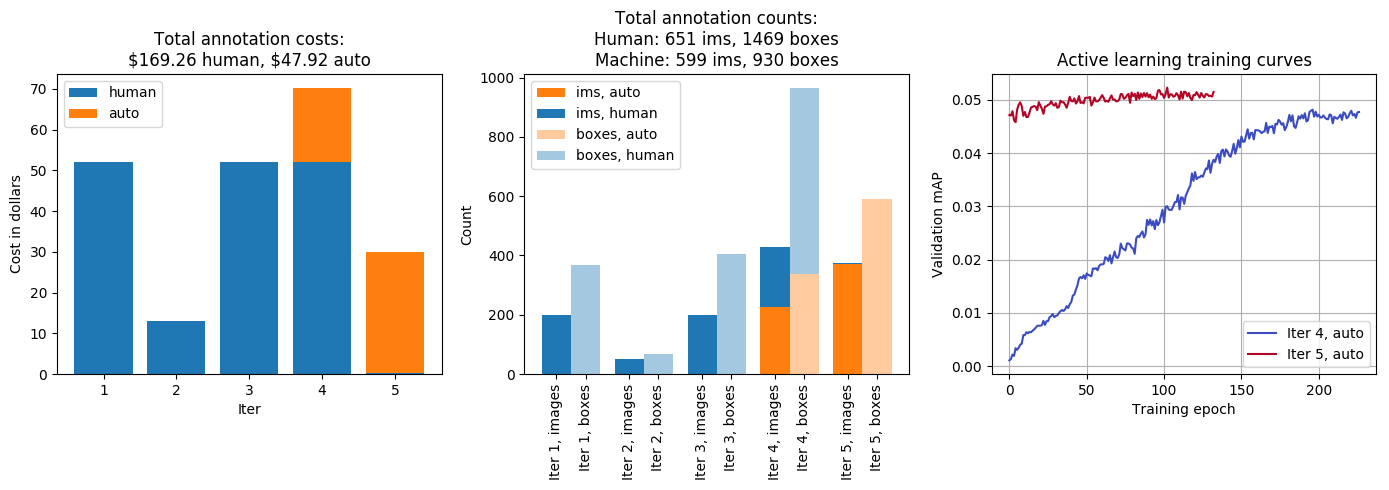

In [18]:
#job_name = 'pretrained-model-iteration-11554764290'

HUMAN_PRICE = 0.26
AUTO_PRICE = 0.08

try:
    os.makedirs('od_output_data/', exist_ok=False)
except FileExistsError:
    shutil.rmtree('od_output_data/')
    
S3_OUTPUT = boto3.client('sagemaker').describe_labeling_job(LabelingJobName=job_name)[
    'OutputConfig']['S3OutputPath'] + job_name

# Count number of human annotations in each class each iteration.
!aws s3 cp {S3_OUTPUT + '/annotations/consolidated-annotation/consolidation-response'} od_output_data/consolidation-response --recursive --quiet
consolidated_nboxes = defaultdict(int)
consolidated_nims = defaultdict(int)
consolidation_times = {}
consolidated_cost_times = []
obj_ids = set()

for consolidated_fname in glob.glob('od_output_data/consolidation-response/**', recursive=True):
    if consolidated_fname.endswith('json'):
        iter_id = int(consolidated_fname.split('/')[-2][-1])
        # Store the time of the most recent consolidation event as iteration time.
        iter_time = datetime.strptime(consolidated_fname.split('/')[-1], '%Y-%m-%d_%H:%M:%S.json')
        if iter_id in consolidation_times:
            consolidation_times[iter_id] = max(consolidation_times[iter_id], iter_time)
        else:
            consolidation_times[iter_id] = iter_time
        consolidated_cost_times.append(iter_time)
                                      
        with open(consolidated_fname, 'r') as f:
            consolidated_data = json.load(f)
        for consolidation in consolidated_data:
            obj_id = consolidation['datasetObjectId']
            n_boxes = len(consolidation['consolidatedAnnotation']['content'][
                'category']['annotations'])
            if obj_id not in obj_ids:
                obj_ids.add(obj_id)
                consolidated_nims[iter_id] += 1            
                consolidated_nboxes[iter_id] += n_boxes
            
total_human_labels = sum(consolidated_nims.values())
            
# Count the number of machine iterations in each class each iteration.
!aws s3 cp {S3_OUTPUT + '/activelearning'} od_output_data/activelearning --recursive --quiet
auto_nboxes = defaultdict(int)
auto_nims = defaultdict(int)
auto_times = {}
auto_cost_times = []

for auto_fname in glob.glob('od_output_data/activelearning/**', recursive=True):
    if auto_fname.endswith('auto_annotator_output.txt'):
        iter_id = int(auto_fname.split('/')[-3])
        with open(auto_fname, 'r') as f:
            annots = [' '.join(l.split()[1:]) for l in f.readlines()]
        auto_nims[iter_id] += len(annots)
        for annot in annots:
            annot = json.loads(annot)
            time_str = annot['category-metadata']['creation-date']
            auto_time = datetime.strptime(time_str, '%Y-%m-%dT%H:%M:%S.%f')
            n_boxes = len(annot['category']['annotations'])
            auto_nboxes[iter_id] += n_boxes
            if iter_id in auto_times:
                auto_times[iter_id] = max(auto_times[iter_id], auto_time)
            else:
                auto_times[iter_id] = auto_time
            auto_cost_times.append(auto_time)
                
total_auto_labels = sum(auto_nims.values())
n_iters = max(len(auto_times), len(consolidation_times))

# Get plots for auto-annotation neural-net training.
def get_training_job_data(training_job_name):
    logclient = boto3.client('logs')
    log_group_name = '/aws/sagemaker/TrainingJobs'
    log_stream_name = logclient.describe_log_streams(logGroupName=log_group_name,
        logStreamNamePrefix=training_job_name)['logStreams'][0]['logStreamName']
    train_log = logclient.get_log_events(
        logGroupName=log_group_name,
        logStreamName=log_stream_name,
        startFromHead=True
    )
    events = train_log['events']
    next_token = train_log['nextForwardToken']
    while True:
        train_log = logclient.get_log_events(
            logGroupName=log_group_name,
            logStreamName=log_stream_name,
            startFromHead=True,
            nextToken=next_token
        )
        if train_log['nextForwardToken'] == next_token:
            break
        events = events + train_log['events']
        next_token = train_log['nextForwardToken']

    mAPs = []
    for event in events:
        msg = event['message']
        if 'Final configuration' in msg:
            num_samples = int(msg.split('num_training_samples\': u\'')[1].split('\'')[0])
        elif 'validation mAP <score>=(' in msg:
            mAPs.append(float(msg.split('validation mAP <score>=(')[1][:-1]))

    return num_samples, mAPs

training_data = !aws s3 ls {S3_OUTPUT + '/training/'} --recursive
training_sizes = []
training_mAPs = []
training_iters = []
for line in training_data:
    if line.split('/')[-1] == 'model.tar.gz':
        training_job_name = line.split('/')[-3]
        n_samples, mAPs = get_training_job_data(training_job_name)
        training_sizes.append(n_samples)
        training_mAPs.append(mAPs)
        training_iters.append(int(line.split('/')[-5]))
        
plt.figure(facecolor='white', figsize=(14, 5), dpi=100)
ax = plt.subplot(131)
total_human = 0
total_auto = 0
for iter_id in range(1, n_iters + 1):
    cost_human = consolidated_nims[iter_id] * HUMAN_PRICE
    cost_auto = auto_nims[iter_id] * AUTO_PRICE
    total_human += cost_human
    total_auto += cost_auto
    
    plt.bar(iter_id, cost_human, width=.8, color='C0',
            label='human' if iter_id==1 else None)
    plt.bar(iter_id, cost_auto, bottom=cost_human,
            width=.8, color='C1', label='auto' if iter_id==1 else None)
plt.title('Total annotation costs:\n\${:.2f} human, \${:.2f} auto'.format(
    total_human, total_auto))
plt.xlabel('Iter')
plt.ylabel('Cost in dollars')
plt.legend()

plt.subplot(132)
plt.title('Total annotation counts:\nHuman: {} ims, {} boxes\nMachine: {} ims, {} boxes'.format(
    sum(consolidated_nims.values()), sum(consolidated_nboxes.values()), sum(auto_nims.values()), sum(auto_nboxes.values())))
for iter_id in consolidated_nims.keys():
    plt.bar(iter_id, auto_nims[iter_id], color='C1', width=.4, label='ims, auto' if iter_id==1 else None)
    plt.bar(iter_id, consolidated_nims[iter_id],
            bottom=auto_nims[iter_id], color='C0', width=.4, label='ims, human' if iter_id==1 else None)
    plt.bar(iter_id + .4, auto_nboxes[iter_id], color='C1', alpha=.4, width=.4, label='boxes, auto' if iter_id==1 else None)
    plt.bar(iter_id + .4, consolidated_nboxes[iter_id],
            bottom=auto_nboxes[iter_id], color='C0', width=.4, alpha=.4, label='boxes, human' if iter_id==1 else None)

tick_labels_boxes = ['Iter {}, boxes'.format(iter_id + 1) for iter_id in range(n_iters)]
tick_labels_images = ['Iter {}, images'.format(iter_id + 1) for iter_id in range(n_iters)]
tick_locations_images = np.arange(n_iters) + 1
tick_locations_boxes = tick_locations_images + .4
tick_labels = np.concatenate([[tick_labels_boxes[idx], tick_labels_images[idx]] for idx in range(n_iters)])
tick_locations = np.concatenate([[tick_locations_boxes[idx], tick_locations_images[idx]] for idx in range(n_iters)])
plt.xticks(tick_locations, tick_labels, rotation=90)
plt.legend()
plt.ylabel('Count')

if len(training_sizes) > 0:
    plt.subplot(133)
    plt.title('Active learning training curves')
    plt.grid(True)

    cmap = plt.get_cmap('coolwarm')
    n_all = len(training_sizes)
    for iter_id_id, (iter_id, size, mAPs) in enumerate(zip(training_iters, training_sizes, training_mAPs)):
        plt.plot(mAPs, label='Iter {}, auto'.format(iter_id + 1), color=cmap(iter_id_id / max(1, (n_all-1))))
        plt.legend()

    plt.xlabel('Training epoch')
    plt.ylabel('Validation mAP')

plt.tight_layout()

## Wait for Completion of Job

Confirm that the labeling job status returns "Completed" before proceeding to the next section.

In [19]:
sagemaker_client.describe_labeling_job(LabelingJobName=job_name)['LabelingJobStatus']

'Completed'

# Iteration #2: Labeling Job with Pre-Trained Model <a class="anchor" id="Iteration2"></a>

Now we'll use the model trained during the first labeling job to help label the second subset of our original dataset.

In [20]:
# Fetch the SageMaker Model ARN of the machine learning model trained in the final iteration of the previous labeling job.
pretrained_model_arn = sagemaker_client.describe_labeling_job(LabelingJobName=job_name)['LabelingJobOutput']['FinalActiveLearningModelArn']

In [23]:
VERIFY_USING_PRIVATE_WORKFORCE = False

task_description = 'Dear Annotator, please draw a box around each {}. Thank you!'.format(CLASS_NAME)
task_keywords = ['image', 'object', 'detection']
task_title = 'Please draw a box around each {}.'.format(CLASS_NAME)
job_name = 'pretrained-model-iteration-2' + str(int(time.time()))

human_task_config = {
      "AnnotationConsolidationConfig": {
        "AnnotationConsolidationLambdaArn": acs_arn,
      },
      "PreHumanTaskLambdaArn": prehuman_arn,
      "MaxConcurrentTaskCount": 200, # 200 images will be sent at a time to the workteam.
      "NumberOfHumanWorkersPerDataObject": 3, # We will obtain and consolidate 3 human annotations for each image.
      "TaskAvailabilityLifetimeInSeconds": 21600, # Your workteam has 6 hours to complete all pending tasks.
      "TaskDescription": task_description,
      "TaskKeywords": task_keywords,
      "TaskTimeLimitInSeconds": 300, # Each image must be labeled within 5 minutes.
      "TaskTitle": task_title,
      "UiConfig": {
        "UiTemplateS3Uri": 's3://{}/{}/instructions.template'.format(BUCKET, EXP_NAME),
      }
    }

if not VERIFY_USING_PRIVATE_WORKFORCE:
    human_task_config["PublicWorkforceTaskPrice"] = {
        "AmountInUsd": {
           "Dollars": 0,
           "Cents": 3,
           "TenthFractionsOfACent": 6,
        }
    } 
    human_task_config["WorkteamArn"] = workteam_arn
else:
    human_task_config["WorkteamArn"] = private_workteam_arn

ground_truth_request = {
        "InputConfig" : {
          "DataSource": {
            "S3DataSource": {
              "ManifestS3Uri": 's3://{}/{}/{}'.format(BUCKET, EXP_NAME_2, manifest_name_iteration_2),
            }
          },
          "DataAttributes": {
            "ContentClassifiers": [
              "FreeOfPersonallyIdentifiableInformation",
              "FreeOfAdultContent"
            ]
          },  
        },
        "OutputConfig" : {
          "S3OutputPath": 's3://{}/{}/output/'.format(BUCKET, EXP_NAME_2),
        },
        "HumanTaskConfig" : human_task_config,
        "LabelingJobName": job_name,
        "RoleArn": role, 
        "LabelAttributeName": "category",
        "LabelCategoryConfigS3Uri": 's3://{}/{}/class_labels.json'.format(BUCKET, EXP_NAME),
    }


ground_truth_request[ "LabelingJobAlgorithmsConfig"] = {
        "InitialActiveLearningModelArn": pretrained_model_arn,
        "LabelingJobAlgorithmSpecificationArn": labeling_algorithm_specification_arn
                                       }
    
sagemaker_client = boto3.client('sagemaker')
sagemaker_client.create_labeling_job(**ground_truth_request)

{'LabelingJobArn': 'arn:aws:sagemaker:us-west-2:776936280910:labeling-job/pretrained-model-iteration-21557968681',
 'ResponseMetadata': {'RequestId': 'f40942ae-c836-437b-807c-bf06e3e6665d',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'f40942ae-c836-437b-807c-bf06e3e6665d',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '113',
   'date': 'Thu, 16 May 2019 01:04:41 GMT'},
  'RetryAttempts': 0}}

## Monitor Job Progress

In [25]:
sagemaker_client.describe_labeling_job(LabelingJobName=job_name)['LabelingJobStatus']

'Completed'

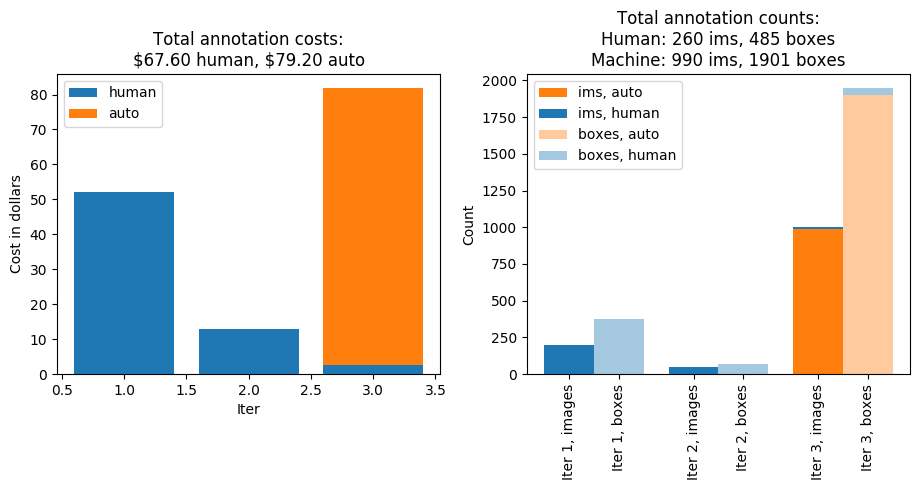

In [27]:
HUMAN_PRICE = 0.26
AUTO_PRICE = 0.08

try:
    !rm -rf od_output_data
    os.makedirs('od_output_data/', exist_ok=False)
except FileExistsError:
    shutil.rmtree('od_output_data/')
    
S3_OUTPUT = boto3.client('sagemaker').describe_labeling_job(LabelingJobName=job_name)[
    'OutputConfig']['S3OutputPath'] + job_name

# Count number of human annotations in each class each iteration.
!aws s3 cp {S3_OUTPUT + '/annotations/consolidated-annotation/consolidation-response'} od_output_data/consolidation-response --recursive --quiet
consolidated_nboxes = defaultdict(int)
consolidated_nims = defaultdict(int)
consolidation_times = {}
consolidated_cost_times = []
obj_ids = set()

for consolidated_fname in glob.glob('od_output_data/consolidation-response/**', recursive=True):
    if consolidated_fname.endswith('json'):
        iter_id = int(consolidated_fname.split('/')[-2][-1])
        # Store the time of the most recent consolidation event as iteration time.
        iter_time = datetime.strptime(consolidated_fname.split('/')[-1], '%Y-%m-%d_%H:%M:%S.json')
        if iter_id in consolidation_times:
            consolidation_times[iter_id] = max(consolidation_times[iter_id], iter_time)
        else:
            consolidation_times[iter_id] = iter_time
        consolidated_cost_times.append(iter_time)
                                      
        with open(consolidated_fname, 'r') as f:
            consolidated_data = json.load(f)
        for consolidation in consolidated_data:
            obj_id = consolidation['datasetObjectId']
            n_boxes = len(consolidation['consolidatedAnnotation']['content'][
                'category']['annotations'])
            if obj_id not in obj_ids:
                obj_ids.add(obj_id)
                consolidated_nims[iter_id] += 1            
                consolidated_nboxes[iter_id] += n_boxes
            
total_human_labels = sum(consolidated_nims.values())
            
# Count the number of machine iterations in each class each iteration.
!aws s3 cp {S3_OUTPUT + '/activelearning'} od_output_data/activelearning --recursive --quiet
auto_nboxes = defaultdict(int)
auto_nims = defaultdict(int)
auto_times = {}
auto_cost_times = []

for auto_fname in glob.glob('od_output_data/activelearning/**', recursive=True):
    if auto_fname.endswith('auto_annotator_output.txt'):
        iter_id = int(auto_fname.split('/')[-3])
        with open(auto_fname, 'r') as f:
            annots = [' '.join(l.split()[1:]) for l in f.readlines()]
        auto_nims[iter_id] += len(annots)
        for annot in annots:
            annot = json.loads(annot)
            time_str = annot['category-metadata']['creation-date']
            auto_time = datetime.strptime(time_str, '%Y-%m-%dT%H:%M:%S.%f')
            n_boxes = len(annot['category']['annotations'])
            auto_nboxes[iter_id] += n_boxes
            if iter_id in auto_times:
                auto_times[iter_id] = max(auto_times[iter_id], auto_time)
            else:
                auto_times[iter_id] = auto_time
            auto_cost_times.append(auto_time)
                
total_auto_labels = sum(auto_nims.values())
n_iters = max(len(auto_times), len(consolidation_times))

# Get plots for auto-annotation neural-net training.
def get_training_job_data(training_job_name):
    logclient = boto3.client('logs')
    log_group_name = '/aws/sagemaker/TrainingJobs'
    log_stream_name = logclient.describe_log_streams(logGroupName=log_group_name,
        logStreamNamePrefix=training_job_name)['logStreams'][0]['logStreamName']
    train_log = logclient.get_log_events(
        logGroupName=log_group_name,
        logStreamName=log_stream_name,
        startFromHead=True
    )
    events = train_log['events']
    next_token = train_log['nextForwardToken']
    while True:
        train_log = logclient.get_log_events(
            logGroupName=log_group_name,
            logStreamName=log_stream_name,
            startFromHead=True,
            nextToken=next_token
        )
        if train_log['nextForwardToken'] == next_token:
            break
        events = events + train_log['events']
        next_token = train_log['nextForwardToken']

    mAPs = []
    for event in events:
        msg = event['message']
        if 'Final configuration' in msg:
            num_samples = int(msg.split('num_training_samples\': u\'')[1].split('\'')[0])
        elif 'validation mAP <score>=(' in msg:
            mAPs.append(float(msg.split('validation mAP <score>=(')[1][:-1]))

    return num_samples, mAPs

training_data = !aws s3 ls {S3_OUTPUT + '/training/'} --recursive
training_sizes = []
training_mAPs = []
training_iters = []
for line in training_data:
    if line.split('/')[-1] == 'model.tar.gz':
        training_job_name = line.split('/')[-3]
        n_samples, mAPs = get_training_job_data(training_job_name)
        training_sizes.append(n_samples)
        training_mAPs.append(mAPs)
        training_iters.append(int(line.split('/')[-5]))
        
plt.figure(facecolor='white', figsize=(14, 5), dpi=100)
ax = plt.subplot(131)
total_human = 0
total_auto = 0
for iter_id in range(1, n_iters + 1):
    cost_human = consolidated_nims[iter_id] * HUMAN_PRICE
    cost_auto = auto_nims[iter_id] * AUTO_PRICE
    total_human += cost_human
    total_auto += cost_auto
    
    plt.bar(iter_id, cost_human, width=.8, color='C0',
            label='human' if iter_id==1 else None)
    plt.bar(iter_id, cost_auto, bottom=cost_human,
            width=.8, color='C1', label='auto' if iter_id==1 else None)
    
plt.title('Total annotation costs:\n\${:.2f} human, \${:.2f} auto'.format(
    total_human, total_auto))
plt.xlabel('Iter')
plt.ylabel('Cost in dollars')
plt.legend()

plt.subplot(132)
plt.title('Total annotation counts:\nHuman: {} ims, {} boxes\nMachine: {} ims, {} boxes'.format(
    sum(consolidated_nims.values()), sum(consolidated_nboxes.values()), sum(auto_nims.values()), sum(auto_nboxes.values())))
for iter_id in consolidated_nims.keys():
    plt.bar(iter_id, auto_nims[iter_id], color='C1', width=.4, label='ims, auto' if iter_id==1 else None)
    plt.bar(iter_id, consolidated_nims[iter_id],
            bottom=auto_nims[iter_id], color='C0', width=.4, label='ims, human' if iter_id==1 else None)
    plt.bar(iter_id + .4, auto_nboxes[iter_id], color='C1', alpha=.4, width=.4, label='boxes, auto' if iter_id==1 else None)
    plt.bar(iter_id + .4, consolidated_nboxes[iter_id],
            bottom=auto_nboxes[iter_id], color='C0', width=.4, alpha=.4, label='boxes, human' if iter_id==1 else None)

tick_labels_boxes = ['Iter {}, boxes'.format(iter_id + 1) for iter_id in range(n_iters)]
tick_labels_images = ['Iter {}, images'.format(iter_id + 1) for iter_id in range(n_iters)]
tick_locations_images = np.arange(n_iters) + 1
tick_locations_boxes = tick_locations_images + .4
tick_labels = np.concatenate([[tick_labels_boxes[idx], tick_labels_images[idx]] for idx in range(n_iters)])
tick_locations = np.concatenate([[tick_locations_boxes[idx], tick_locations_images[idx]] for idx in range(n_iters)])
plt.xticks(tick_locations, tick_labels, rotation=90)
plt.legend()
plt.ylabel('Count')

if len(training_sizes) > 0:
    plt.subplot(133)
    plt.title('Active learning training curves')
    plt.grid(True)

    cmap = plt.get_cmap('coolwarm')
    n_all = len(training_sizes)
    for iter_id_id, (iter_id, size, mAPs) in enumerate(zip(training_iters, training_sizes, training_mAPs)):
        plt.plot(mAPs, label='Iter {}, auto'.format(iter_id + 1), color=cmap(iter_id_id / max(1, (n_all-1))))
        plt.legend()

    plt.xlabel('Training epoch')
    plt.ylabel('Validation mAP')

plt.tight_layout()

## Wait for Completion of Job

Confirm that the labeling job status returns "Completed" before proceeding to the next section.

In [28]:
sagemaker_client.describe_labeling_job(LabelingJobName=job_name)['LabelingJobStatus']

'Completed'

# Iteration #3: Second Data Subset Without Pre-Trained Model <a class="anchor" id="Iteration3"></a>

This time, we'll create a new labeling job using the second subset of the data (the one we just used in the previous labeling job), but we'll start it without the pre-trained model. In the previous step, we saw some significant improvements in cost and labeling time by leveraging a pre-trained model, but some of the differences might be due to the fact that the first and second labeling jobs used different datasets. This third labeling job will provide a more fair comparison, since it is identical to the second labeling job without the pre-trained model specification.

In [55]:
VERIFY_USING_PRIVATE_WORKFORCE = False
USE_AUTO_LABELING = True

task_description = 'Dear Annotator, please draw a box around each {}. Thank you!'.format(CLASS_NAME)
task_keywords = ['image', 'object', 'detection']
task_title = 'Please draw a box around each {}.'.format(CLASS_NAME)
job_name = 'pretrained-model-iteration-3EX' + str(int(time.time()))

human_task_config = {
      "AnnotationConsolidationConfig": {
        "AnnotationConsolidationLambdaArn": acs_arn,
      },
      "PreHumanTaskLambdaArn": prehuman_arn,
      "MaxConcurrentTaskCount": 200, # 200 images will be sent at a time to the workteam.
      "NumberOfHumanWorkersPerDataObject": 3, # We will obtain and consolidate 3 human annotations for each image.
      "TaskAvailabilityLifetimeInSeconds": 43200, # Your workteam has 6 hours to complete all pending tasks.
      "TaskDescription": task_description,
      "TaskKeywords": task_keywords,
      "TaskTimeLimitInSeconds": 300, # Each image must be labeled within 5 minutes.
      "TaskTitle": task_title,
      "UiConfig": {
        "UiTemplateS3Uri": 's3://{}/{}/instructions.template'.format(BUCKET, EXP_NAME),
      }
    }

if not VERIFY_USING_PRIVATE_WORKFORCE:
    human_task_config["PublicWorkforceTaskPrice"] = {
        "AmountInUsd": {
           "Dollars": 0,
           "Cents": 3,
           "TenthFractionsOfACent": 6,
        }
    } 
    human_task_config["WorkteamArn"] = workteam_arn
else:
    human_task_config["WorkteamArn"] = private_workteam_arn

ground_truth_request = {
        "InputConfig" : {
          "DataSource": {
            "S3DataSource": {
              "ManifestS3Uri": 's3://{}/{}/{}'.format(BUCKET, EXP_NAME_2, manifest_name_iteration_2),
            }
          },
          "DataAttributes": {
            "ContentClassifiers": [
              "FreeOfPersonallyIdentifiableInformation",
              "FreeOfAdultContent"
            ]
          },  
        },
        "OutputConfig" : {
          "S3OutputPath": 's3://{}/{}/output/'.format(BUCKET, EXP_NAME_3),
        },
        "HumanTaskConfig" : human_task_config,
        "LabelingJobName": job_name,
        "RoleArn": role, 
        "LabelAttributeName": "category",
        "LabelCategoryConfigS3Uri": 's3://{}/{}/class_labels.json'.format(BUCKET, EXP_NAME),
    }

if USE_AUTO_LABELING:
    ground_truth_request[ "LabelingJobAlgorithmsConfig"] = {
            "LabelingJobAlgorithmSpecificationArn": labeling_algorithm_specification_arn
                                       }
    
sagemaker_client = boto3.client('sagemaker')
sagemaker_client.create_labeling_job(**ground_truth_request)

{'LabelingJobArn': 'arn:aws:sagemaker:us-west-2:776936280910:labeling-job/pretrained-model-iteration-3ex1558056590',
 'ResponseMetadata': {'RequestId': '8b0d64ff-e44f-4cc8-9edd-b42b23ea4949',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '8b0d64ff-e44f-4cc8-9edd-b42b23ea4949',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '115',
   'date': 'Fri, 17 May 2019 01:29:50 GMT'},
  'RetryAttempts': 0}}

## Monitor Job Progress

In [4]:
job_name = 'pretrained-model-iteration-3EX1558036839'
sagemaker_client.describe_labeling_job(LabelingJobName=job_name)['LabelingJobStatus']

'Completed'

## Post-Process Job

About to get training job logs


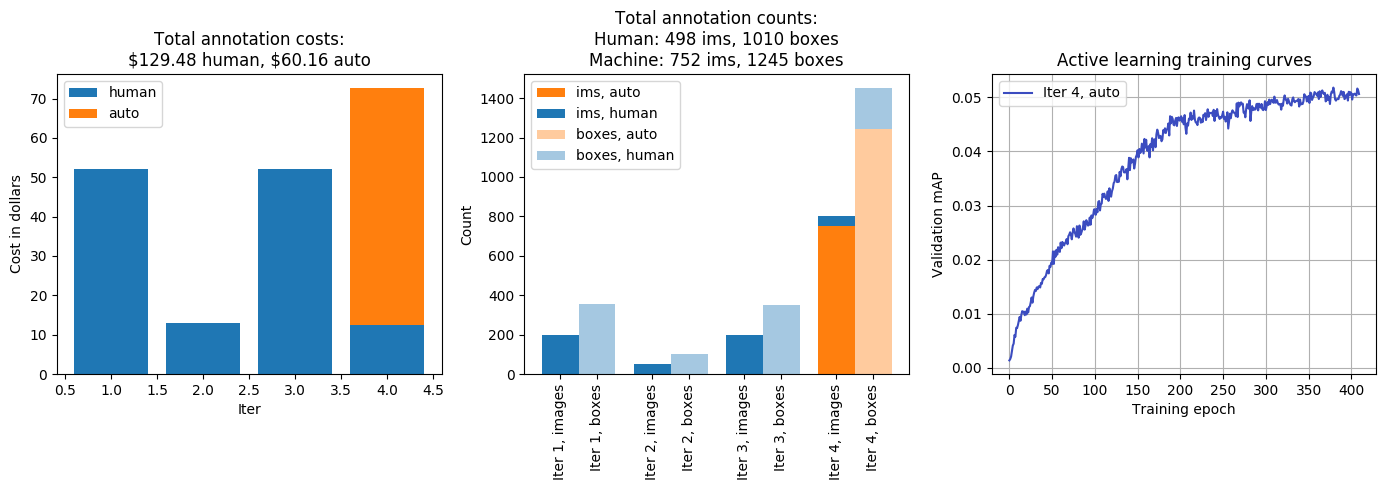

In [11]:
HUMAN_PRICE = 0.26
AUTO_PRICE = 0.08

try:
    !rm -rf od_output_data
    os.makedirs('od_output_data/', exist_ok=False)
except FileExistsError:
    shutil.rmtree('od_output_data/')
    
S3_OUTPUT = boto3.client('sagemaker').describe_labeling_job(LabelingJobName=job_name)[
    'OutputConfig']['S3OutputPath'] + job_name

# Count number of human annotations in each class each iteration.
!aws s3 cp {S3_OUTPUT + '/annotations/consolidated-annotation/consolidation-response'} od_output_data/consolidation-response --recursive --quiet
consolidated_nboxes = defaultdict(int)
consolidated_nims = defaultdict(int)
consolidation_times = {}
consolidated_cost_times = []
obj_ids = set()

for consolidated_fname in glob.glob('od_output_data/consolidation-response/**', recursive=True):
    if consolidated_fname.endswith('json'):
        iter_id = int(consolidated_fname.split('/')[-2][-1])
        # Store the time of the most recent consolidation event as iteration time.
        iter_time = datetime.strptime(consolidated_fname.split('/')[-1], '%Y-%m-%d_%H:%M:%S.json')
        if iter_id in consolidation_times:
            consolidation_times[iter_id] = max(consolidation_times[iter_id], iter_time)
        else:
            consolidation_times[iter_id] = iter_time
        consolidated_cost_times.append(iter_time)
                                      
        with open(consolidated_fname, 'r') as f:
            consolidated_data = json.load(f)
        for consolidation in consolidated_data:
            obj_id = consolidation['datasetObjectId']
            n_boxes = len(consolidation['consolidatedAnnotation']['content'][
                'category']['annotations'])
            if obj_id not in obj_ids:
                obj_ids.add(obj_id)
                consolidated_nims[iter_id] += 1            
                consolidated_nboxes[iter_id] += n_boxes
            
total_human_labels = sum(consolidated_nims.values())
            
# Count the number of machine iterations in each class each iteration.
!aws s3 cp {S3_OUTPUT + '/activelearning'} od_output_data/activelearning --recursive --quiet
auto_nboxes = defaultdict(int)
auto_nims = defaultdict(int)
auto_times = {}
auto_cost_times = []

for auto_fname in glob.glob('od_output_data/activelearning/**', recursive=True):
    if auto_fname.endswith('auto_annotator_output.txt'):
        iter_id = int(auto_fname.split('/')[-3])
        with open(auto_fname, 'r') as f:
            annots = [' '.join(l.split()[1:]) for l in f.readlines()]
        auto_nims[iter_id] += len(annots)
        for annot in annots:
            annot = json.loads(annot)
            time_str = annot['category-metadata']['creation-date']
            auto_time = datetime.strptime(time_str, '%Y-%m-%dT%H:%M:%S.%f')
            n_boxes = len(annot['category']['annotations'])
            auto_nboxes[iter_id] += n_boxes
            if iter_id in auto_times:
                auto_times[iter_id] = max(auto_times[iter_id], auto_time)
            else:
                auto_times[iter_id] = auto_time
            auto_cost_times.append(auto_time)
                
total_auto_labels = sum(auto_nims.values())
n_iters = max(len(auto_times), len(consolidation_times))

# Get plots for auto-annotation neural-net training.
def get_training_job_data(training_job_name):
    logclient = boto3.client('logs')
    log_group_name = '/aws/sagemaker/TrainingJobs'
    log_stream_name = logclient.describe_log_streams(logGroupName=log_group_name,
        logStreamNamePrefix=training_job_name)['logStreams'][0]['logStreamName']
    train_log = logclient.get_log_events(
        logGroupName=log_group_name,
        logStreamName=log_stream_name,
        startFromHead=True
    )
    events = train_log['events']
    next_token = train_log['nextForwardToken']
    while True:
        train_log = logclient.get_log_events(
            logGroupName=log_group_name,
            logStreamName=log_stream_name,
            startFromHead=True,
            nextToken=next_token
        )
        if train_log['nextForwardToken'] == next_token:
            break
        events = events + train_log['events']
        next_token = train_log['nextForwardToken']

    mAPs = []
    for event in events:
        msg = event['message']
        if 'Final configuration' in msg:
            num_samples = int(msg.split('num_training_samples\': u\'')[1].split('\'')[0])
        elif 'validation mAP <score>=(' in msg:
            mAPs.append(float(msg.split('validation mAP <score>=(')[1][:-1]))

    return num_samples, mAPs

training_data = !aws s3 ls {S3_OUTPUT + '/training/'} --recursive
training_sizes = []
training_mAPs = []
training_iters = []
for line in training_data:
    if line.split('/')[-1] == 'model.tar.gz':
        training_job_name = line.split('/')[-3]
        print('About to get training job logs')
        n_samples, mAPs = get_training_job_data(training_job_name)
        training_sizes.append(n_samples)
        training_mAPs.append(mAPs)
        training_iters.append(int(line.split('/')[-5]))
        
plt.figure(facecolor='white', figsize=(14, 5), dpi=100)
ax = plt.subplot(131)
total_human = 0
total_auto = 0
for iter_id in range(1, n_iters + 1):
    cost_human = consolidated_nims[iter_id] * HUMAN_PRICE
    cost_auto = auto_nims[iter_id] * AUTO_PRICE
    total_human += cost_human
    total_auto += cost_auto
    
    plt.bar(iter_id, cost_human, width=.8, color='C0',
            label='human' if iter_id==1 else None)
    plt.bar(iter_id, cost_auto, bottom=cost_human,
            width=.8, color='C1', label='auto' if iter_id==1 else None)   

plt.title('Total annotation costs:\n\${:.2f} human, \${:.2f} auto'.format(
    total_human, total_auto))
plt.xlabel('Iter')
plt.ylabel('Cost in dollars')
plt.legend()

plt.subplot(132)
plt.title('Total annotation counts:\nHuman: {} ims, {} boxes\nMachine: {} ims, {} boxes'.format(
    sum(consolidated_nims.values()), sum(consolidated_nboxes.values()), sum(auto_nims.values()), sum(auto_nboxes.values())))
for iter_id in consolidated_nims.keys():
    plt.bar(iter_id, auto_nims[iter_id], color='C1', width=.4, label='ims, auto' if iter_id==1 else None)
    plt.bar(iter_id, consolidated_nims[iter_id],
            bottom=auto_nims[iter_id], color='C0', width=.4, label='ims, human' if iter_id==1 else None)
    plt.bar(iter_id + .4, auto_nboxes[iter_id], color='C1', alpha=.4, width=.4, label='boxes, auto' if iter_id==1 else None)
    plt.bar(iter_id + .4, consolidated_nboxes[iter_id],
            bottom=auto_nboxes[iter_id], color='C0', width=.4, alpha=.4, label='boxes, human' if iter_id==1 else None)

tick_labels_boxes = ['Iter {}, boxes'.format(iter_id + 1) for iter_id in range(n_iters)]
tick_labels_images = ['Iter {}, images'.format(iter_id + 1) for iter_id in range(n_iters)]
tick_locations_images = np.arange(n_iters) + 1
tick_locations_boxes = tick_locations_images + .4
tick_labels = np.concatenate([[tick_labels_boxes[idx], tick_labels_images[idx]] for idx in range(n_iters)])
tick_locations = np.concatenate([[tick_locations_boxes[idx], tick_locations_images[idx]] for idx in range(n_iters)])
plt.xticks(tick_locations, tick_labels, rotation=90)
plt.legend()
plt.ylabel('Count')

if len(training_sizes) > 0:
    plt.subplot(133)
    plt.title('Active learning training curves')
    plt.grid(True)

    cmap = plt.get_cmap('coolwarm')
    n_all = len(training_sizes)
    for iter_id_id, (iter_id, size, mAPs) in enumerate(zip(training_iters, training_sizes, training_mAPs)):
        plt.plot(mAPs, label='Iter {}, auto'.format(iter_id + 1), color=cmap(iter_id_id / max(1, (n_all-1))))
        plt.legend()

    plt.xlabel('Training epoch')
    plt.ylabel('Validation mAP')

plt.tight_layout()

# Conclusion <a class="anchor" id="Conclusion"></a>

This marks the conclusion of our sample notebook demonstrating the use of pre-trained models to accelerate labeling jobs. Let's review what we covered.

* We gathered a dataset consisting of 2500 images of birds from the Open Images dataset.
* We split this dataset into two halves. 
* We created a labeling job for the first dataset of 1250 images and saw that approximately 48% of the dataset was machine-labeled. 
* We created a second labeling job for the second dataset, and we specified the machine learning model that was trained during the first labeling job. This time we found that approximately 80% of the dataset was machine-labeled.
* As a final benchmark, we re-ran the second labeling job without specifying the pre-trained model. Now we found that approximately 60% of the dataset was machine-labeled. 

That's it! If we were to acquire a new unlabeled dataset in this domain (e.g., object detection of birds), we could setup another labeling job, and specify the model trained in our second labeling job. The use of pre-trained machine learning models allows you to run labeling jobs in succession, with each job improving from the predictive ability gained through the previous job.  Remember that the capability to use pre-trained models is only available through the SageMaker Ground Truth API.